In [42]:
# from google.colab import drive
# drive.mount('/content/drive')

In [43]:
# !pip install pyvi

In [44]:
import numpy as np
import pandas as pd
import string
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from pyvi import ViTokenizer
import re
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [45]:
data = pd.read_excel("/content/drive/MyDrive/data/News/data VN/vntoken.xlsx")

In [46]:
data.head()

,URL,Title,Summary,Contents,Date,Author(s),Category,Tags
0,https://laodong.vn/ban-doc/cach-tham-gia-bao-h...,Cách tham gia Bảo hiểm xã hội tự nguyện sau kh...,Bảo hiểm xã hội Việt Nam thông tin về mức đóng...,Bạn đọc hỏi: Tôi mới đi làm và tham gia Bảo hi...,"Thứ tư, 22/09/2021 10:00 (GMT+7)",ANH THƯ,Bạn đọc,"['Bảo hiểm xã hội', 'Bảo hiểm xã hội Việt Nam'..."
1,https://laodong.vn/ban-doc/quang-tri-cay-co-da...,Quảng Trị: Cây cọ dầu ở nơi có dự án của Vingr...,Quảng Trị - Ở địa điểm xây dựng khu đô thị thư...,"Sau khi đấu giá trúng khu đất rộng 132.415,6 m...","Thứ tư, 09/03/2022 18:13 (GMT+7)",HƯNG THƠ,Bạn đọc,"['Quảng Trị', 'Dự án Vingroup ở Quảng Trị', 'V..."
2,https://laodong.vn/ban-doc/lao-cai-dan-khat-nu...,Lào Cai: Dân khát nước bên công trình nước sạc...,Lào Cai – Hàng trăm hộ dân vẫn phải dùng nước ...,"Phản ánh đến PV, người dân xã Cam Đường, TP.Là...","Thứ tư, 11/05/2022 16:57 (GMT+7)",Văn Đức,Bạn đọc,"['Lào Cai', 'Nước sạch', 'nhà máy nước sạch', ..."
3,https://laodong.vn/ban-doc/quy-dinh-ve-viec-la...,Quy định về việc làm giám định sức khoẻ để ngh...,Bạn đọc Hà My hỏi: Tôi có làm giám định sức kh...,"Về vấn đề trên, Bảo hiểm xã hội Việt Nam trả l...","Chủ nhật, 20/06/2021 20:16 (GMT+7)",Minh Hương,Bạn đọc,"['Bảo hiểm xã hội', 'Luật Bảo hiểm xã hội', 'N..."
4,https://laodong.vn/ban-doc/iphone-12-va-dang-c...,iPhone 12 và đẳng cấp “móc túi” người dùng của...,Âm thầm tăng giá bán nhưng lại giảm phụ kiện đ...,"Nếu là iFan, hẳn các bạn còn nhớ, ngày 11.9.20...","Thứ năm, 15/10/2020 06:58 (GMT+7)",Đạt Phan,Bạn đọc,"['Bảo vệ môi trường', 'Apple', 'Iphone', 'Appl..."


In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39000 entries, 0 to 38999
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   URL        39000 non-null  object
 1   Title      39000 non-null  object
 2   Summary    38413 non-null  object
 3   Contents   36961 non-null  object
 4   Date       39000 non-null  object
 5   Author(s)  38234 non-null  object
 6   Category   39000 non-null  object
 7   Tags       39000 non-null  object
dtypes: object(8)
memory usage: 2.4+ MB


In [48]:
data.shape

(39000, 8)

In [49]:
num_categories = data['Category'].nunique()
print(f'Số lượng thể loại có trong bộ dữ liệu: {num_categories}')

Số lượng thể loại có trong bộ dữ liệu: 39


In [50]:
# # Tải bộ stop word Tiếng Việt
# !gdown 1NHM08W6U9xkf2ajuotD6QWQBBSvp5jj6

In [51]:

# Kiểm tra các giá trị trùng lặp và các dòng bị thiếu dữ liệu
print('Giá trị trùng lặp:',data.duplicated().sum())
print("\nGiá trị bị thiếu:")
data.isnull().sum()

Giá trị trùng lặp: 20687

Giá trị bị thiếu:


URL             0
Title           0
Summary       587
Contents     2039
Date            0
Author(s)     766
Category        0
Tags            0
dtype: int64

In [52]:

# Xoá các dòng chứa giá trị trùng lặp và các dòng bị thiếu dữ liệu
data.drop_duplicates(inplace = True)
data.dropna(inplace = True)
data.reset_index(drop = True, inplace = True)


In [53]:
print('\nSố lượng bài viết của từng thể loại:')
category_counts = data['Category'].value_counts()
category_counts



Số lượng bài viết của từng thể loại:


Pháp luật                     985
Thế giới                      975
Kinh doanh                    966
Thể thao                      965
Xã hội                        964
Sức khỏe                      952
Công đoàn                     951
Thời sự                       948
Giáo dục                      945
Văn hóa - Giải trí            941
Media                         921
Bạn đọc                       920
Gia đình - Hôn nhân           873
Bất động sản                  869
Xe +                          826
Tấm Lòng Vàng                 727
Công nghệ                     582
Lao Động cuối tuần            495
Lưu trữ                       379
Lao Động & Đời sống           319
Diễn đàn                      278
Tin hoạt động                 216
Tin tức việc làm              166
Thông tin tiện ích             96
Sự kiện Bình luận              58
Phóng sự                       47
Tin địa phương                 31
Quỹ TLV                        28
Thông tin doanh nghiệp         15
Tin bài xem th

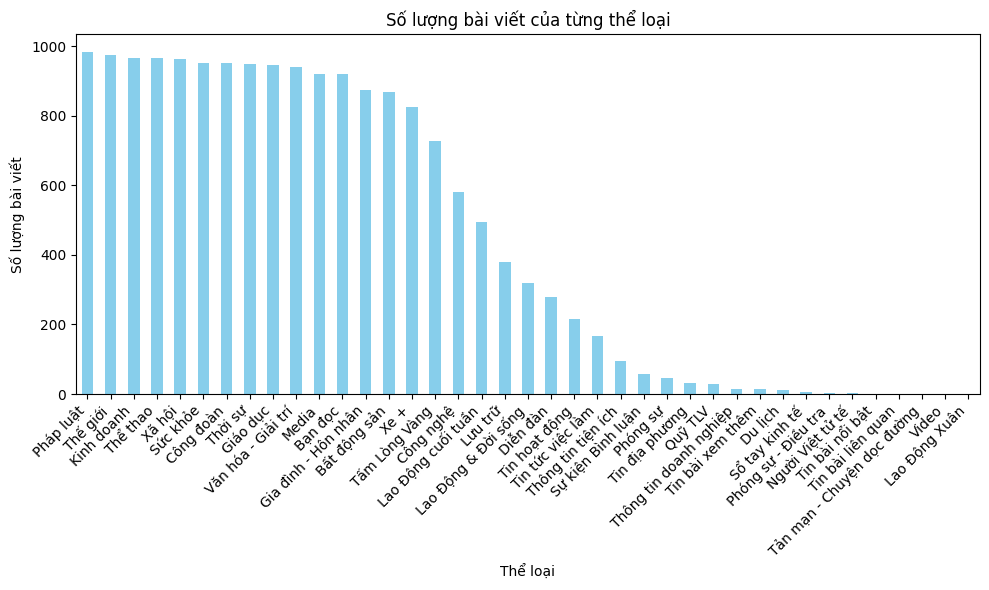

In [54]:
plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar', color='skyblue')
plt.title('Số lượng bài viết của từng thể loại')
plt.xlabel('Thể loại')
plt.ylabel('Số lượng bài viết')
plt.xticks(rotation=45, ha='right')  # Xoay nhãn trục x nếu cần
plt.tight_layout()
plt.show()

In [55]:

category_mapping = {
    'Lao Động Xuân': 'Lao Động & Đời sống',
    'Video': 'Media',
    'Tản mạn - Chuyện dọc đường': 'Bạn đọc',
    'Phóng sự - Điều tra': 'Thời sự',
    'Thông tin doanh nghiệp': 'Kinh doanh',
    'Lao Động cuối tuần': 'Lao Động & Đời sống',
    'Người Việt tử tế': 'Tấm Lòng Vàng',
    'Sổ tay kinh tế': 'Kinh doanh',
    'Quỹ TLV': 'Tấm Lòng Vàng',
    'Tin địa phương': 'Thời sự',
    'Du lịch': 'Văn hóa - Giải trí',
    'Phóng sự': 'Thời sự'
}


# Áp dụng việc thay đổi nhãn
data['Category'] = data['Category'].replace(category_mapping)
data['Category'].value_counts()

Thời sự                1028
Kinh doanh              988
Pháp luật               985
Thế giới                975
Thể thao                965
Xã hội                  964
Sức khỏe                952
Văn hóa - Giải trí      952
Công đoàn               951
Giáo dục                945
Media                   922
Bạn đọc                 921
Gia đình - Hôn nhân     873
Bất động sản            869
Xe +                    826
Lao Động & Đời sống     815
Tấm Lòng Vàng           757
Công nghệ               582
Lưu trữ                 379
Diễn đàn                278
Tin hoạt động           216
Tin tức việc làm        166
Thông tin tiện ích       96
Sự kiện Bình luận        58
Tin bài xem thêm         13
Tin bài liên quan         1
Tin bài nổi bật           1
Name: Category, dtype: int64

In [56]:
data.drop(data[data['Category'] == 'Lưu trữ'].index,inplace= True)
data.drop(data[data['Category'] == 'Tin hoạt động'].index,inplace= True)
data.drop(data[data['Category'] == 'Diễn đàn'].index,inplace= True)
data.drop(data[data['Category'] == 'Sự kiện Bình luận'].index,inplace= True)
data.drop(data[data['Category'].isin(['Tin bài nổi bật','Tin bài liên quan','Tin bài xem thêm','Lao Động & Đời sống','Bạn đọc','Media','Công đoàn','Xã hội','Kinh doanh','Thời sự'])].index,inplace= True)
data.reset_index(drop = True, inplace = True)

In [57]:
num_categories = data['Category'].nunique()
print(f'Số lượng thể loại có trong bộ dữ liệu: {num_categories}')
print('Số lượng bài viết của từng thể loại:')
data['Category'].value_counts()

Số lượng thể loại có trong bộ dữ liệu: 13
Số lượng bài viết của từng thể loại:


Pháp luật              985
Thế giới               975
Thể thao               965
Văn hóa - Giải trí     952
Sức khỏe               952
Giáo dục               945
Gia đình - Hôn nhân    873
Bất động sản           869
Xe +                   826
Tấm Lòng Vàng          757
Công nghệ              582
Tin tức việc làm       166
Thông tin tiện ích      96
Name: Category, dtype: int64

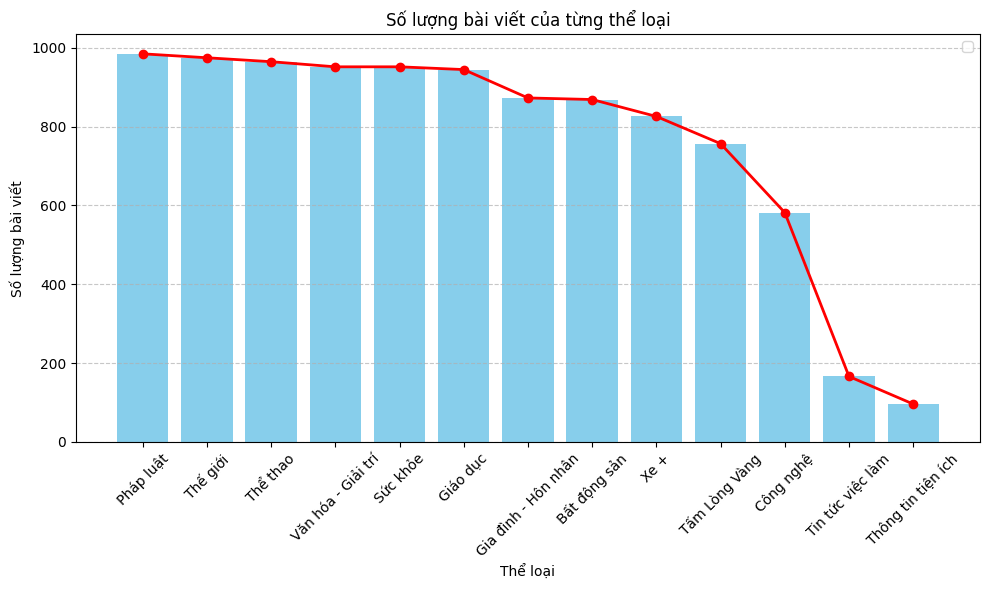

In [58]:
import matplotlib.pyplot as plt

# Tính toán số lượng bài viết của mỗi thể loại
category_counts = data['Category'].value_counts()

import matplotlib.pyplot as plt

# Tính toán số lượng bài viết của mỗi thể loại
category_counts = data['Category'].value_counts()

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.plot(category_counts.index, category_counts.values, marker='o', color='red', linewidth=2)
plt.bar(category_counts.index, category_counts.values, color='skyblue')
plt.title('Số lượng bài viết của từng thể loại')
plt.xlabel('Thể loại')
plt.ylabel('Số lượng bài viết')
plt.xticks(rotation=45)
plt.legend()  # Hiển thị chú thích
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



In [59]:
data_df = data[['Category','Summary']]
data_df

,Category,Summary
0,Bất động sản,"Bước sang quý III.2019, giao dịch bất động sản..."
1,Bất động sản,Tin tưởng vào việc hùn vốn với giám đốc công t...
2,Bất động sản,Chủ tịch UBND tỉnh Bắc Ninh vừa phê duyệt quy ...
3,Bất động sản,Chuyển đổi quyền sử dụng đất (đổi đất) chỉ áp ...
4,Bất động sản,Không ai phủ nhận ý nghĩa của Đề án giãn dân p...
...,...,...
9938,Xe +,"Mới đây, trên mạng xã hội giao thông đăng tải ..."
9939,Xe +,"Theo thống kê của Uỷ ban ATGT Quốc gia, trong ..."
9940,Xe +,Ca sĩ Lily Chen tậu xe Mercedes G63 AMG có giá...
9941,Xe +,"Xe máy sau một thời gian vận hành, một số bộ p..."


In [60]:
def text_preprocessing(sent):
    sent = str(sent)

    with open('/content/drive/MyDrive/data/News/data VN/vietnamese.txt', 'r', encoding='utf-8') as f:
        stop_words = f.read().split('\n')

    sent = re.sub(f'[{string.punctuation}\d\n]', '', sent)
    sent = re.sub(r'[^\w\s]', '', sent)
    sent = ViTokenizer.tokenize(sent.lower())
    sent = [w for w in sent.split()]
    sent = [w for w in sent if w not in stop_words]
    return ' '.join(sent)

In [61]:
data_df['tokenized_contents'] = data['Summary'].apply(lambda x: text_preprocessing(x))
data_df

,Category,Summary,tokenized_contents
0,Bất động sản,"Bước sang quý III.2019, giao dịch bất động sản...",quý iii giao_dịch bất_động_sản thị_trường đà_n...
1,Bất động sản,Tin tưởng vào việc hùn vốn với giám đốc công t...,tin_tưởng hùn vốn giám_đốc công_ty bất_động_sả...
2,Bất động sản,Chủ tịch UBND tỉnh Bắc Ninh vừa phê duyệt quy ...,chủ_tịch ubnd tỉnh bắc ninh phê_duyệt quy_hoạc...
3,Bất động sản,Chuyển đổi quyền sử dụng đất (đổi đất) chỉ áp ...,chuyển_đổi quyền sử_dụng đất đổi đất áp_dụng đ...
4,Bất động sản,Không ai phủ nhận ý nghĩa của Đề án giãn dân p...,phủ_nhận ý_nghĩa đề_án giãn dân_phố cổ hà_nội ...
...,...,...,...
9938,Xe +,"Mới đây, trên mạng xã hội giao thông đăng tải ...",mới_đây mạng xã_hội giao_thông đăng_tải clip b...
9939,Xe +,"Theo thống kê của Uỷ ban ATGT Quốc gia, trong ...",thống_kê uỷ_ban atgt quốc_gia đầu toàn_quốc xả...
9940,Xe +,Ca sĩ Lily Chen tậu xe Mercedes G63 AMG có giá...,ca_sĩ lily chen tậu xe mercedes g amg có_giá l...
9941,Xe +,"Xe máy sau một thời gian vận hành, một số bộ p...",xe_máy thời_gian vận_hành một_số bộ_phận rơ rã...


In [62]:
# Chia thành cột tokenized_contents và cột Category
lstm_train_data = data_df
sentences = lstm_train_data['tokenized_contents'].tolist()
labels = lstm_train_data['Category'].tolist()
lstm_train_data['Category'].unique()

array(['Bất động sản', 'Công nghệ', 'Văn hóa - Giải trí',
       'Gia đình - Hôn nhân', 'Giáo dục', 'Tấm Lòng Vàng', 'Pháp luật',
       'Sức khỏe', 'Thông tin tiện ích', 'Thế giới', 'Thể thao',
       'Tin tức việc làm', 'Xe +'], dtype=object)

In [63]:
# Sử dụng LabelEncoder để mã hóa nhãn
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_encoded

array([ 0,  0,  0, ..., 12, 12, 12])

In [64]:
# Xử lý dữ liệu văn bản
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
sequences = tokenizer.texts_to_sequences(sentences)
sequences[:1]

[[501,
  2623,
  94,
  47,
  75,
  2,
  51,
  34,
  5,
  364,
  398,
  1044,
  1716,
  14,
  78,
  14,
  123,
  793,
  211,
  953,
  706,
  588,
  266,
  208,
  34,
  5]]

In [65]:
# Chia thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(sequences, labels_encoded, test_size=0.2, random_state=42)


In [66]:
# Chuẩn bị nhãn
num_classes = len(label_encoder.classes_)
one_hot_labels_train = to_categorical(y_train, num_classes=num_classes)
one_hot_labels_test = to_categorical(y_test, num_classes=num_classes)

In [67]:
# Xử lý dữ liệu đầu vào
max_length = max(len(seq) for seq in sequences)
X_train = pad_sequences(X_train, maxlen=max_length)
X_test = pad_sequences(X_test, maxlen=max_length)
X_train

array([[   0,    0,    0, ...,  201,    8,    4],
       [   0,    0,    0, ...,  996,  708,  340],
       [   0,    0,    0, ..., 1102,  481,    5],
       ...,
       [   0,    0,    0, ..., 6316, 6317, 6318],
       [   0,    0,    0, ...,  150,  928,   39],
       [   0,    0,    0, ...,  159, 2924, 3395]], dtype=int32)

In [68]:
from keras.layers import Dropout
embedding_dim = 100

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(16))  # Số chiều đầu ra của LSTM cuối cùng
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 215, 100)          828500    
                                                                 
 lstm_4 (LSTM)               (None, 215, 128)          117248    
                                                                 
 dropout_3 (Dropout)         (None, 215, 128)          0         
                                                                 
 lstm_5 (LSTM)               (None, 215, 64)           49408     
                                                                 
 dropout_4 (Dropout)         (None, 215, 64)           0         
                                                                 
 lstm_6 (LSTM)               (None, 215, 32)           12416     
                                                                 
 dropout_5 (Dropout)         (None, 215, 32)          

In [69]:
history = model.fit(X_train, one_hot_labels_train, epochs=10, batch_size=32, validation_data=(X_test, one_hot_labels_test))

Epoch 1/10
249/249 [==============================] - 27s 80ms/step - loss: 2.1834 - accuracy: 0.2052 - val_loss: 1.8802 - val_accuracy: 0.3318
Epoch 2/10
249/249 [==============================] - 10s 41ms/step - loss: 1.5731 - accuracy: 0.4555 - val_loss: 1.4867 - val_accuracy: 0.5053
Epoch 3/10
249/249 [==============================] - 9s 38ms/step - loss: 1.1566 - accuracy: 0.6362 - val_loss: 1.2404 - val_accuracy: 0.6078
Epoch 4/10
249/249 [==============================] - 9s 37ms/step - loss: 0.8704 - accuracy: 0.7460 - val_loss: 1.0654 - val_accuracy: 0.6853
Epoch 5/10
249/249 [==============================] - 9s 35ms/step - loss: 0.6692 - accuracy: 0.8187 - val_loss: 1.0091 - val_accuracy: 0.7179
Epoch 6/10
249/249 [==============================] - 9s 35ms/step - loss: 0.5118 - accuracy: 0.8696 - val_loss: 1.0232 - val_accuracy: 0.7215
Epoch 7/10
249/249 [==============================] - 9s 36ms/step - loss: 0.4153 - accuracy: 0.8989 - val_loss: 1.0248 - val_accuracy: 0.72

In [70]:
# Đánh giá mô hình trên tập kiểm tra
loss, accuracy = model.evaluate(X_test, one_hot_labels_test)
print('Loss:', loss)
print('Accuracy:', accuracy)

63/63 [==============================] - 1s 12ms/step - loss: 1.0389 - accuracy: 0.7396
Loss: 1.0389206409454346
Accuracy: 0.7395676374435425


In [71]:
from sklearn.metrics import classification_report
# Đánh giá mô hình trên tập kiểm tra
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(one_hot_labels_test, axis=1)

print(classification_report(y_test, y_pred))

63/63 [==============================] - 2s 11ms/step
              precision    recall  f1-score   support

           0       0.91      0.65      0.76       185
           1       0.53      0.59      0.56       116
           2       0.62      0.62      0.62       180
           3       0.87      0.87      0.87       187
           4       0.84      0.73      0.78       194
           5       0.71      0.72      0.71       194
           6       0.82      0.86      0.84        21
           7       0.70      0.67      0.68       183
           8       0.92      0.80      0.86       187
           9       0.85      0.61      0.71        38
          10       0.88      0.82      0.85       156
          11       0.55      0.78      0.65       196
          12       0.73      0.88      0.80       152

    accuracy                           0.74      1989
   macro avg       0.76      0.74      0.74      1989
weighted avg       0.76      0.74      0.74      1989



In [72]:
# # Lưu mô hình với encoding UTF-8
# joblib.dump(model, 'lstm_model.joblib')

In [79]:

import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [80]:
batch_size = 32
epochs = 1

train_times = []  # Lưu trữ thời gian huấn luyện

for i in range(10):
    start_time = time.time()
    history = model.fit(X_train, one_hot_labels_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, one_hot_labels_test))
    end_time = time.time()
    train_time = end_time - start_time
    train_times.append(train_time)
    print(f"Completed training {i + 1} time(s). Training time: {train_time:.2f}s")

249/249 [==============================] - 9s 35ms/step - loss: 0.2289 - accuracy: 0.9453 - val_loss: 1.0906 - val_accuracy: 0.7421
Completed training 1 time(s). Training time: 8.71s
249/249 [==============================] - 8s 33ms/step - loss: 0.2008 - accuracy: 0.9534 - val_loss: 1.0960 - val_accuracy: 0.7541
Completed training 2 time(s). Training time: 10.32s
249/249 [==============================] - 9s 38ms/step - loss: 0.1746 - accuracy: 0.9612 - val_loss: 1.0876 - val_accuracy: 0.7552
Completed training 3 time(s). Training time: 10.29s
249/249 [==============================] - 9s 35ms/step - loss: 0.1522 - accuracy: 0.9666 - val_loss: 1.1687 - val_accuracy: 0.7401
Completed training 4 time(s). Training time: 10.29s
249/249 [==============================] - 9s 35ms/step - loss: 0.1406 - accuracy: 0.9677 - val_loss: 1.1300 - val_accuracy: 0.7526
Completed training 5 time(s). Training time: 8.76s
249/249 [==============================] - 8s 33ms/step - loss: 0.1236 - accuracy:

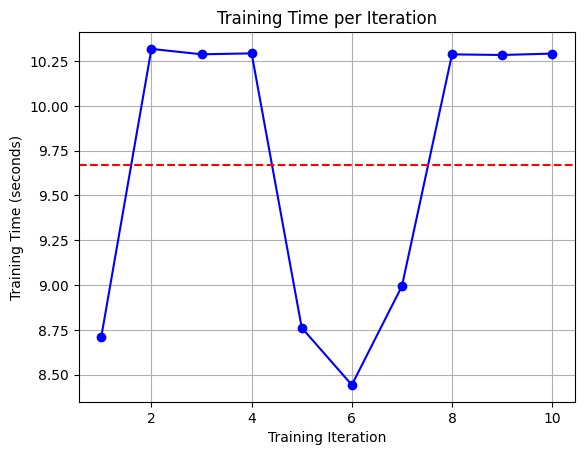

In [81]:
# Vẽ đồ thị thời gian huấn luyện
plt.plot(range(1, 11, 1), train_times, marker='o', linestyle='-', color='blue')
plt.axhline(y=np.mean(train_times), color='red', linestyle='--')
plt.xlabel('Training Iteration')
plt.ylabel('Training Time (seconds)')
plt.title('Training Time per Iteration')
plt.grid(True)
plt.show()


63/63 [==============================] - 1s 17ms/step


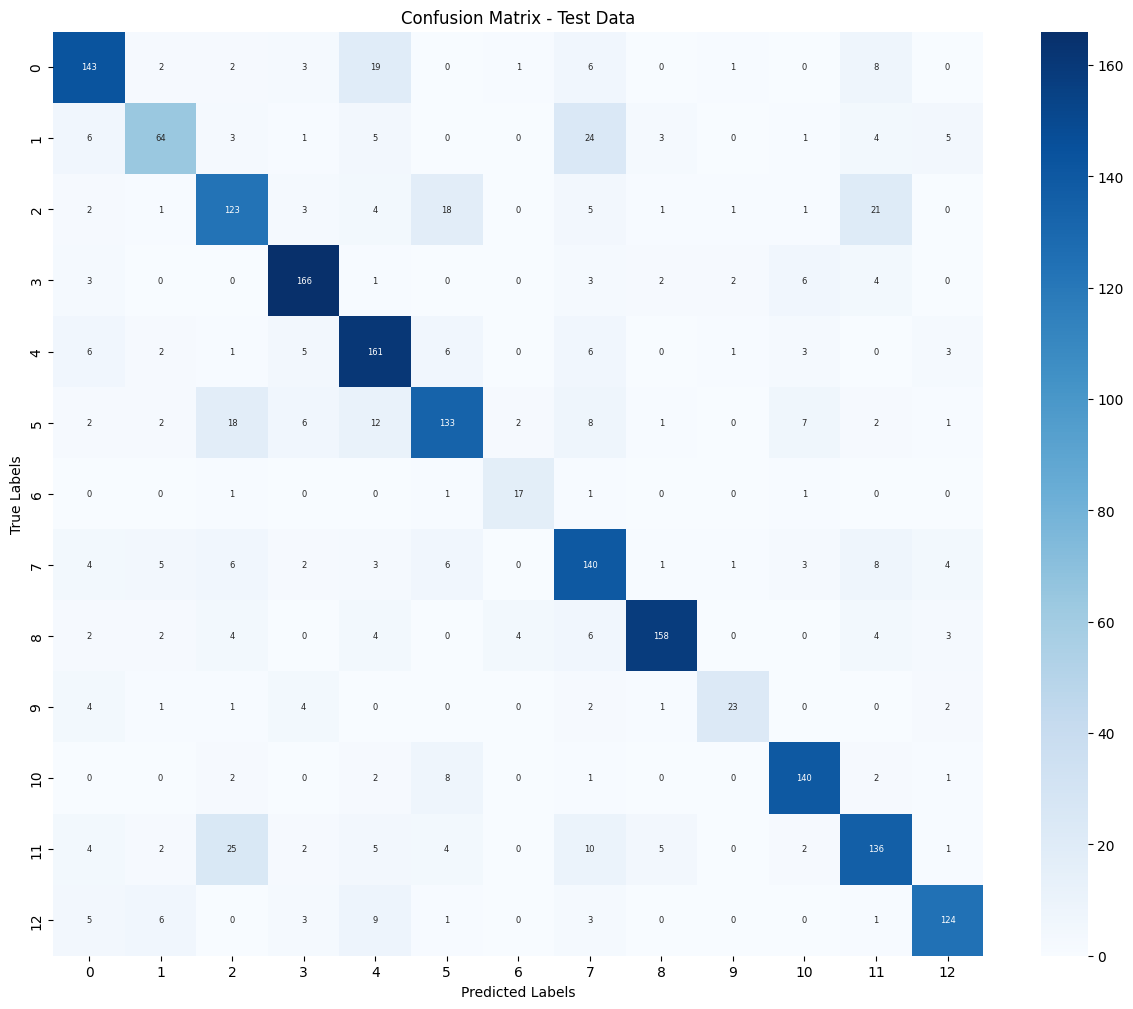

In [82]:
# Biểu diễn trực quan mô hình (Dự đoán - Thực tế)

# Dự đoán nhãn trên tập kiểm tra
test_predictions = model.predict(X_test)
test_predicted_labels = label_encoder.inverse_transform(np.argmax(test_predictions, axis=1))

# Tính toán ma trận nhầm lẫn trên tập kiểm tra
test_cm = confusion_matrix(label_encoder.inverse_transform(np.argmax(one_hot_labels_test, axis=1)), test_predicted_labels)

# Trực quan hóa ma trận nhầm lẫn trên tập kiểm tra
plt.figure(figsize=(15, 12))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', annot_kws={"fontsize": 6})
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Test Data')
plt.show()

# Dự đoán

In [73]:
stopword_file = '/content/drive/MyDrive/data/News/data VN/vietnamese.txt'

In [74]:
# Đọc danh sách từ stopword từ tệp
with open(stopword_file, 'r', encoding='utf-8') as f:
    stopword_list = [word.strip() for word in f.readlines()]

In [75]:
# Chuẩn bị 5 câu test ngẫu nhiên
import random

new_sentences = data['Summary'].tolist()

random_indexes = random.sample(range(len(new_sentences)), 5)
random_sentences = [new_sentences[i] for i in random_indexes]

print("Câu test:", random_sentences)

Câu test: ['Các nhà nghiên cứu cho rằng, tinh tinh nắm chặt tay nhau khi chải chuốt cho nhau và mỗi nhóm có cách nắm tay riêng biệt, tương tự như hành vi bắt tay ở người.', 'Điều người mua chung cư quan tâm chính là thủ tục xin cấp sổ hồng và những khoản lệ phí phải nộp.', 'Các bậc phụ huynh cần quan tâm hướng dẫn các bé cách ăn uống lịch sự, gọn gàng và tránh mắc những lỗi cơ bản.', 'Sau khi bà xã sinh con đầu lòng, diễn viên Chi Bảo mạnh tay chi khoảng 20 tỉ đồng sắm Bentley Flying Spur tặng vợ.', 'Tại các thành phố lớn, khi diện tích ngày càng hạn hẹp, phương tiện đi lại gia tăng thì việc thiết kế gara ô tô, nhất là đối với nhà ống được đặc biệt quan tâm.']


In [76]:
# Tiền xử lý câu mới
preprocessed_sentences = []
for sentence in random_sentences:
    preprocessed_sentence = re.sub(r'[^\w\s]', '', sentence)  # Loại bỏ dấu câu không cần thiết
    preprocessed_sentence = ViTokenizer.tokenize(preprocessed_sentence)   # Tokenize câu sử dụng ViTokenizer
    words = preprocessed_sentence.split()
    words = [word for word in words if word.lower() not in stopword_list]  # Loại bỏ stopword
    preprocessed_sentence = ' '.join(words)
    preprocessed_sentences.append(preprocessed_sentence)

In [77]:
# Chuyển đổi câu mới thành chuỗi số
new_sequences_5 = tokenizer.texts_to_sequences(preprocessed_sentences)
new_sequences_5 = pad_sequences(new_sequences_5, maxlen=max_length)



In [78]:
# Dự đoán nhãn cho 5 câu ngẫu nhiên
predictions_5 = model.predict(new_sequences_5)
predicted_labels_5 = label_encoder.inverse_transform(np.argmax(predictions_5, axis=1))

# In kết quả dự đoán cho 5 câu
for sentence, label in zip(random_sentences, predicted_labels_5):
    print("Câu test:", sentence)
    print("Giá trị dự đoán:", label)
    print()

1/1 [==============================] - 0s 26ms/step
Câu test: Các nhà nghiên cứu cho rằng, tinh tinh nắm chặt tay nhau khi chải chuốt cho nhau và mỗi nhóm có cách nắm tay riêng biệt, tương tự như hành vi bắt tay ở người.
Giá trị dự đoán: Công nghệ

Câu test: Điều người mua chung cư quan tâm chính là thủ tục xin cấp sổ hồng và những khoản lệ phí phải nộp.
Giá trị dự đoán: Bất động sản

Câu test: Các bậc phụ huynh cần quan tâm hướng dẫn các bé cách ăn uống lịch sự, gọn gàng và tránh mắc những lỗi cơ bản.
Giá trị dự đoán: Gia đình - Hôn nhân

Câu test: Sau khi bà xã sinh con đầu lòng, diễn viên Chi Bảo mạnh tay chi khoảng 20 tỉ đồng sắm Bentley Flying Spur tặng vợ.
Giá trị dự đoán: Xe +

Câu test: Tại các thành phố lớn, khi diện tích ngày càng hạn hẹp, phương tiện đi lại gia tăng thì việc thiết kế gara ô tô, nhất là đối với nhà ống được đặc biệt quan tâm.
Giá trị dự đoán: Bất động sản



In [93]:
new_sentences = [
    "TPO - Luật sư của bà Trương Mỹ Lan đề nghị HĐXX xem xét lại tội danh ""Tham ô tài sản"", tuy nhiên đại diện Viện Kiểm sát khẳng định truy tố tội danh này đối với bà Lan là có cơ sở."
]
# Tiền xử lý câu mới
preprocessed_sentences = []
for sentence in new_sentences:
    sentence = re.sub(r'[^\w\s]', '', sentence)
    sentence = ViTokenizer.tokenize(sentence)
    words = sentence.split()
    words = [word for word in words if word.lower() not in stopword_list]
    sentence = ' '.join(words)
    preprocessed_sentences.append(sentence)

# Chuyển đổi câu mới thành chuỗi số
new_sequences = tokenizer.texts_to_sequences(preprocessed_sentences)
new_sequences = pad_sequences(new_sequences, maxlen=max_length)

# Dự đoán nhãn cho các câu mới
predictions = model.predict(new_sequences)
predicted_labels = label_encoder.inverse_transform(np.argmax(predictions, axis=1))

# In kết quả dự đoán
for sentence, label in zip(new_sentences, predicted_labels):
    print("Sentence:", sentence)
    print("Predicted label:", label)
    print()


1/1 [==============================] - 0s 79ms/step
Sentence: TPO - Luật sư của bà Trương Mỹ Lan đề nghị HĐXX xem xét lại tội danh Tham ô tài sản, tuy nhiên đại diện Viện Kiểm sát khẳng định truy tố tội danh này đối với bà Lan là có cơ sở.
Predicted label: Pháp luật



In [ ]:
# Trong thời gian qua, Liên đoàn bóng đá Việt Nam (VFF) đã nhận được khá nhiều đơn ứng cử ghế HLV trưởng đội tuyển quốc gia. Cùng điểm qua một vài HLV danh tiếng trong danh sách này.
# Những mẫu ô tô mới có thể ra mắt Việt Nam ngay trong tháng 4 toàn bộ là xe gầm cao, chủ yếu nằm ở phân khúc phổ thông có giá bán dễ tiếp cận.
# Công nghệ AI đang thay đổi cách chúng ta tương tác với thế giới, từ việc giúp chúng ta tìm kiếm thông tin nhanh chóng đến việc tạo ra trợ lý ảo thông minh.